# Preprocessing Data

Tahap preprocessing bertujuan untuk mengubah data mentah
menjadi representasi numerik yang siap digunakan
oleh algoritma machine learning.

Pada tahap ini dilakukan langkah-langkah berikut:
1. Menggabungkan data train dan test bawaan dataset
2. Melakukan pembagian ulang data (70% train, 30% test) secara stratified
3. Encoding label kelas
4. Ekstraksi fitur MFCC

Urutan ini dipilih untuk memastikan konsistensi data,
menghindari data leakage, dan menjaga distribusi kelas.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os

from google.colab import drive
drive.mount('/content/drive')

!pip -q install sktime librosa scikit-learn

import librosa
from sktime.datasets import load_from_tsfile_to_dataframe
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


ModuleNotFoundError: No module named 'google'

In [11]:
def load_ts(path):
    X_df, y = load_from_tsfile_to_dataframe(path)
    X = np.array([X_df.iloc[i, 0].values for i in range(len(X_df))], dtype=np.float32)
    return X, y

train_path = "/content/drive/MyDrive/MATKUL/PSD/UAS/dataset/DucksAndGeese_TRAIN.ts"
test_path  = "/content/drive/MyDrive/MATKUL/PSD/UAS/dataset/DucksAndGeese_TEST.ts"

X_train_raw, y_train_raw = load_ts(train_path)
X_test_raw,  y_test_raw  = load_ts(test_path)




## 1. Menggabungkan Dataset Train dan Test

Dataset DucksAndGeese disediakan dalam dua file terpisah,
yaitu data training dan data testing.

Pada penelitian ini, kedua dataset digabung terlebih dahulu
untuk memungkinkan pembagian ulang data
dengan rasio yang sesuai kebutuhan eksperimen.


In [ ]:
X_all = np.concatenate([X_train_raw, X_test_raw], axis=0)
y_all = np.concatenate([y_train_raw, y_test_raw], axis=0)

## 2. Pembagian Ulang Data (70% Train, 30% Test)

Setelah data digabung, dilakukan pembagian ulang dataset
menjadi data training dan data testing.

Pembagian dilakukan menggunakan **stratified sampling**
untuk memastikan proporsi setiap kelas
tetap sama pada data training dan testing.


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X_all, y_all, test_size=0.3, random_state=42, stratify=y_all
)

print("Train:", X_train.shape, "Test:", X_test.shape)

Train: (70, 236784) Test: (30, 236784)


Dataset dibagi menjadi:
- 70% data training
- 30% data testing

Pembagian dilakukan secara **stratified**,
artinya proporsi setiap kelas tetap sama
pada data training dan testing.


## 3. Encoding Label Kelas

Label pada dataset masih berbentuk **teks (string)**, seperti
`black-bellied_whistling_duck` atau `canadian_goose`.

Sebagian besar algoritma machine learning, termasuk SVM,
membutuhkan label dalam bentuk **numerik**.
Oleh karena itu, dilakukan proses **Label Encoding**.

Label Encoding mengubah setiap kelas menjadi bilangan bulat unik,
tanpa memberikan makna urutan (ordinal).


In [13]:
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc  = le.transform(y_test)

print("Label mapping:")
for i, cls in enumerate(le.classes_):
    print(i, "->", cls)


Label mapping:
0 -> black-bellied_whistling_duck
1 -> canadian_goose
2 -> greylag_goose
3 -> pink-footed_goose
4 -> white-faced_whistling_duck


## 4. Normalisasi Z-score

Setiap sinyal time-series memiliki skala amplitudo yang berbeda,
tergantung pada kondisi perekaman suara.

Untuk menyamakan skala antar sampel,
digunakan **normalisasi Z-score** yang dilakukan
**per time-series (per sampel)**.

Normalisasi Z-score didefinisikan sebagai:

$$z = \frac{x - \mu}{\sigma}$$

di mana:
- $x$ = nilai sinyal
- $\mu$ = rata-rata sinyal
- $\sigma$ = standar deviasi sinyal

Jika $\sigma = 0$, maka digunakan nilai 1
untuk menghindari pembagian dengan nol.

In [14]:
def normalize_timeseries(X):
    Xn = np.zeros_like(X)
    for i in range(X.shape[0]):
        mean = X[i].mean()
        std  = X[i].std() if X[i].std() != 0 else 1.0
        Xn[i] = (X[i] - mean) / std
    return Xn

X_train_norm = normalize_timeseries(X_train)
X_test_norm  = normalize_timeseries(X_test)


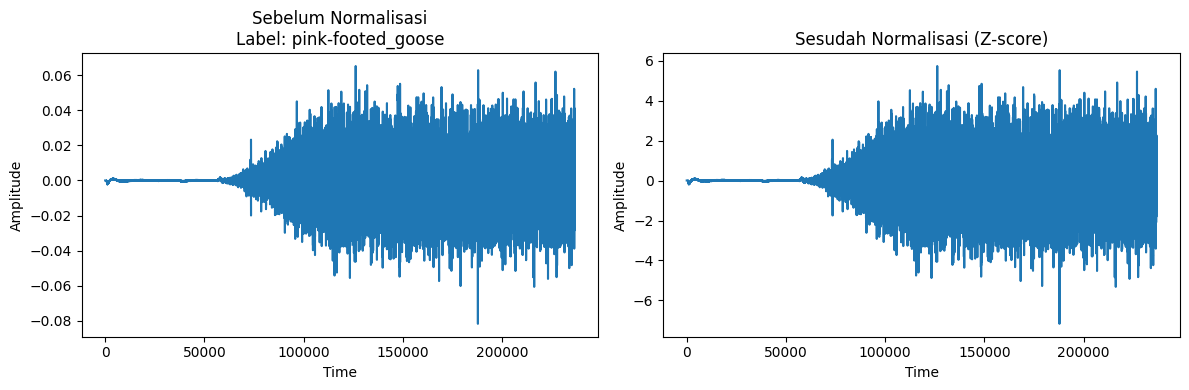

In [15]:
idx = 0

plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(X_train[idx])
plt.title(f"Sebelum Normalisasi\nLabel: {y_train[idx]}")
plt.xlabel("Time")
plt.ylabel("Amplitude")

plt.subplot(1,2,2)
plt.plot(X_train_norm[idx])
plt.title("Sesudah Normalisasi (Z-score)")
plt.xlabel("Time")
plt.ylabel("Amplitude")

plt.tight_layout()
plt.show()


Visualisasi tersebut digunakan untuk memastikan bahwa:
- sinyal sudah terpusat di sekitar nol,
- variasi amplitudo antar sampel menjadi seragam.


## 5. Ekstraksi Fitur MFCC

Mel-Frequency Cepstral Coefficients (MFCC) digunakan
untuk mengekstraksi karakteristik spektral dari sinyal suara.

MFCC mampu merepresentasikan informasi frekuensi
yang relevan dengan persepsi pendengaran manusia
dan umum digunakan pada tugas klasifikasi audio.


Karena dataset tidak memiliki informasi sample rate asli,
digunakan **dummy sample rate** yang konsisten.

Parameter yang digunakan:
- Jumlah MFCC: 20
- Sample rate: 22050 Hz


In [16]:
N_MFCC = 20
DUMMY_SR = 22050  # librosa butuh sr numerik

def extract_mfcc_features(X, n_mfcc=N_MFCC, sr=DUMMY_SR):
    feats = []
    for i in range(X.shape[0]):
        mfcc = librosa.feature.mfcc(y=X[i], sr=sr, n_mfcc=n_mfcc)
        feat = np.concatenate([
            mfcc.mean(axis=1),
            mfcc.std(axis=1),
            mfcc.min(axis=1),
            mfcc.max(axis=1),
        ])
        feats.append(feat)
    return np.array(feats, dtype=np.float32)

X_train_feat = extract_mfcc_features(X_train_norm)
X_test_feat  = extract_mfcc_features(X_test_norm)

print("Feature train:", X_train_feat.shape)


Feature train: (70, 80)


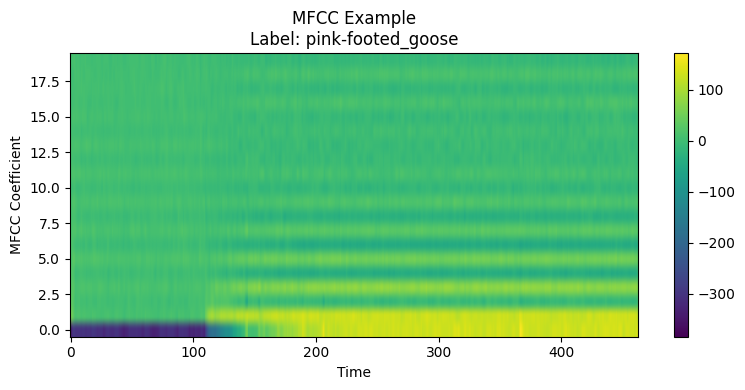

In [17]:
mfcc_example = librosa.feature.mfcc(
    y=X_train_norm[0],
    sr=DUMMY_SR,
    n_mfcc=N_MFCC
)

plt.figure(figsize=(8,4))
plt.imshow(mfcc_example, aspect="auto", origin="lower")
plt.colorbar()
plt.title(f"MFCC Example\nLabel: {y_train[0]}")
plt.xlabel("Time")
plt.ylabel("MFCC Coefficient")
plt.tight_layout()
plt.show()


Kesimpulan tahap preprocessing:
1. Data training dan testing bawaan dataset telah digabung
2. Dataset dibagi ulang menjadi 70% training dan 30% testing secara stratified
3. Label kelas telah diencoding menjadi numerik
4. Sinyal telah dinormalisasi menggunakan Z-score
5. Fitur MFCC berhasil diekstraksi

Data kini siap digunakan pada tahap **Modeling**.
